In [1]:
import os
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision.transforms.functional as TF
from gradcam.utils.image import show_cam_on_image
from gradcam.student_cam import ActionErrTarget, StudentCAM
from pipelines.models.student import StudentPolicy

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
device = torch.device('cuda')
prefix = "step_000358_"

In [3]:
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
sample_rgb = multimae_path / f"samples/{prefix}rgb.png"
sample_depth = multimae_path / f"samples/{prefix}depth.npy"
sample_semseg = multimae_path / f"samples/{prefix}semseg.png"
sample_label = multimae_path / f"samples/{prefix}label.npz"

(224, 224, 3)
actions [ 0.8515812   0.14076994 -0.20107059  0.12248046]


(-0.5, 639.5, 479.5, -0.5)

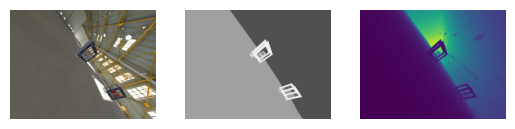

In [4]:
image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

state_inputs = np.load(str(sample_label))
print("actions", state_inputs["act"])

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = np.load(str(sample_depth))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

In [5]:
DOMAINS = ['rgb']

student_save_path = flightmare_path / "flightpy/snaga_results/students/teacher_PPO_25/multivit_02-18-14-43-24"
model_cfg_path = student_save_path / "config_model.yaml"
model_config = yaml.safe_load(open(model_cfg_path, "r"))
model_name = list(model_config.keys())[0] 
student_policy = StudentPolicy(model_config, model_name)

saved_model_path = student_save_path / "model/multivit_ep063_gp_7.25_vl_0.00_10009984.pth"
saved_variables = torch.load(saved_model_path, map_location=device)
student_policy.load_state_dict(saved_variables["state_dict"], strict=True)
student_policy.to(device)
print(f"Load student policy's weights from {saved_model_path}")

Load student policy's weights from /home/chunwei/Documents/drone_offboard/flightmare_internal/flightpy/snaga_results/students/teacher_PPO_25/multivit_02-18-14-43-24/model/multivit_ep063_gp_7.25_vl_0.00_10009984.pth


In [6]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, -1]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

input_dict = {k: np.repeat(v, 8, axis=4) for k, v in input_dict.items()}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

inputs = {k: torch.from_numpy(input_dict[k]) for k in DOMAINS}

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 3, 8)
(1, 480, 640, 1, 8)
(1, 480, 640, 1, 8)


In [7]:
torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 196 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

In [8]:
student_action = student_policy(inputs, require_grad=True, input_data_format="embed")
print(student_action.cpu().detach().numpy())

[[0.99552083 0.1752     0.06618926 0.1565843 ]]


In [9]:
target_layers = [student_policy.embedding_layer.vit_model.encoder[-1].norm1]
action_label = torch.from_numpy(state_inputs["act"]).float().to(device)
targets = [ActionErrTarget(action_label)]

cam = StudentCAM(model=student_policy,
                  target_layers=target_layers,
                  use_cuda=True)

grayscale_cam = cam(input_tensor=inputs, 
                    targets=targets, 
                    # inputs for the student policy
                    require_grad=True, 
                    input_data_format="embed"
                    )
print(grayscale_cam.shape)

(8, 224, 224)


(-0.5, 639.5, 479.5, -0.5)

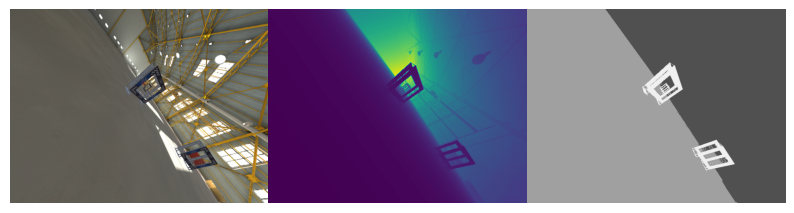

In [10]:
fig = plt.figure(figsize=(10, 10))
axs = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0)

axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(depth)
axs[1].axis('off')
axs[2].imshow(semseg * 80)       
axs[2].axis('off')                                                                                                  

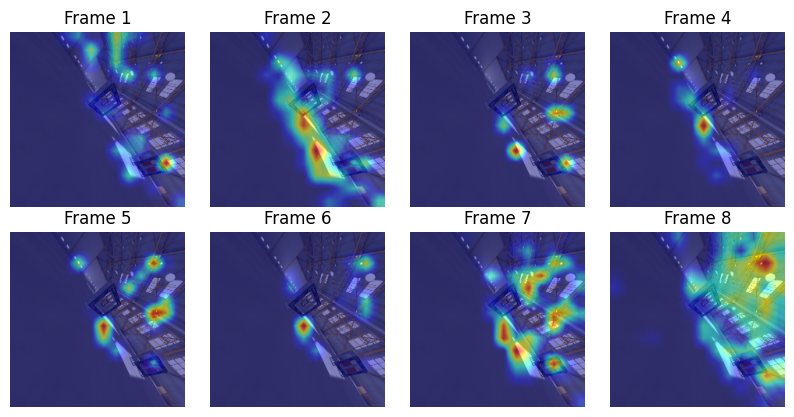

: 

In [11]:
fig = plt.figure(figsize=(10, 10))
axs = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.25)

for i in range(8):
    cam_image = show_cam_on_image(image_float, grayscale_cam[i, :, :], use_rgb=True)
    axs[i].imshow(cam_image)
    axs[i].axis('off')
    axs[i].set_title(f"Frame {i+1}")